### Importing the libraries and files

In [2]:
cd Desktop/Amazon Kindle Store Review

/Users/dillonquan/Desktop/Amazon Kindle Store Review


In [3]:
#Data Wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#Text Preprocessing
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#model training and tuning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

#ignore the warnings from sklearn
import warnings
warnings.filterwarnings('ignore')

In [4]:
#importing the data
df = pd.read_csv('kindle_reviews.csv')

### Exploratory Data Analysis

This dataset provides text reviews on books written by amazon kindle users along with an explicit rating between 1-5.  The goal of this notebook is to practice preprocessing text and developing models to predict users sentiment towards the product. Given the explicit scale, the sentiment is divided by ratings where ratings between 3-5 would be classify as Enjoyed (binary one) the book while ratings 1-2 would be classify as disliked (binary zero). 

The dataset's features are represented as follows:

asin - ID of the product, like B000FA64PK

helpful - helpfulness rating of the review - example: 2/3.

overall - rating of the product.

reviewText - text of the review (heading).

reviewTime - time of the review (raw).

reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN

reviewerName - name of the reviewer.

summary - summary of the review (description).

unixReviewTime - unix timestamp.

In [5]:
#Looking at the general information about the dataset. It seems there are some missing reivewText.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
Unnamed: 0        982619 non-null int64
asin              982619 non-null object
helpful           982619 non-null object
overall           982619 non-null int64
reviewText        982597 non-null object
reviewTime        982619 non-null object
reviewerID        982619 non-null object
reviewerName      978809 non-null object
summary           982618 non-null object
unixReviewTime    982619 non-null int64
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


In [6]:
# 22 missing reviews and needs to be dropped
df.isnull().sum()

Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText          22
reviewTime           0
reviewerID           0
reviewerName      3810
summary              1
unixReviewTime       0
dtype: int64

In [7]:
#contained an extra Unnamed column
df.drop(df.columns[0], axis = 1, inplace = True)

#drop the rows where there are no reviews
df.dropna(subset = ['reviewText'], inplace = True)

#changing the reviewTime column to be of datetime type
df.reviewTime = pd.to_datetime(df.reviewTime)

#creating a column with just the year
df['Year'] = df.reviewTime.dt.year
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Year
0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,2014-05-05,A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,2014
1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,2014-01-06,AN0N05A9LIJEQ,critters,Different...,1388966400,2014
2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,2014-04-04,A795DMNCJILA6,dot,Oldie,1396569600,2014
3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,2014-02-19,A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,2014
4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...",2014-03-19,A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,2014


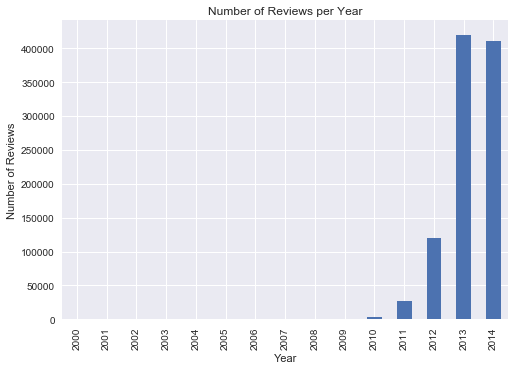

In [9]:
#number of reviews per year, it seems almost all reviews came from 2013 and 2014
df.Year.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

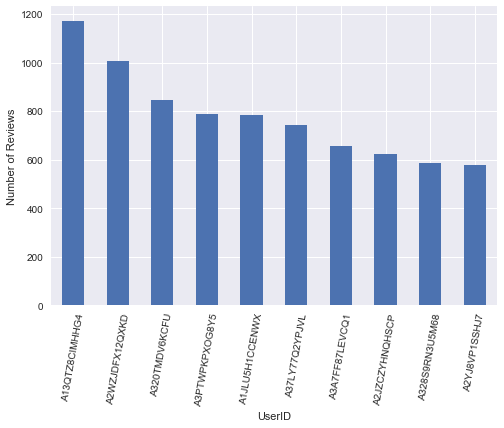

In [10]:
#top 10 users base on the number of reviews made
df.reviewerID.value_counts().head(10).plot(kind = 'bar')
plt.xticks(rotation = 80)
plt.xlabel('UserID')
plt.ylabel('Number of Reviews')
plt.show()

In [11]:
#the overall average review on all the ratings. Seems to be skewed to have above average ratings.
df.overall.mean()

4.347791617519695

In [12]:
#the disparity between the rating scale is huge, could perform some downsample to have each class roughly have 20k samples
df.overall.value_counts()

5    575246
4    254010
3     96193
2     34130
1     23018
Name: overall, dtype: int64

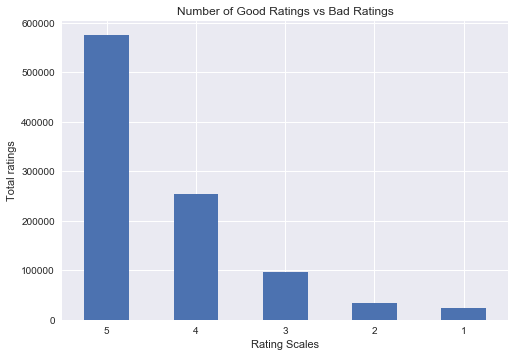

In [14]:
#Take a deeper look into how many ratings we have per scale. Theres are more good ratings than there are bad ratings.
df.overall.value_counts().plot(kind = 'bar')
plt.title('Number of Good Ratings vs Bad Ratings')
plt.xlabel('Rating Scales')
plt.xticks(rotation = 0)
plt.ylabel('Total ratings')
plt.show()

### Text Preprocessing

The following cells provide the steps taken to preprocess the review texts for better feature extraction. Once the text has been preprocessed, it can then be used to develop a vocabulary for training.

1. Removing punctuations
2. Removing non alphabetical words
3. Lowercasing all words
4. Removing stopwords
5. Lemmatization to reduce words to their base form

In [19]:
#created a dataframe that only contains the reviewText and the overall scoring of item
reviews = df[['reviewText', 'overall']]
reviews.head()

,reviewText,overall
0,I enjoy vintage books and movies so I enjoyed ...,5
1,This book is a reissue of an old one; the auth...,4
2,This was a fairly interesting read. It had ol...,4
3,I'd never read any of the Amy Brewster mysteri...,5
4,"If you like period pieces - clothing, lingo, y...",4


In [20]:
print('Original Text: ' + str(reviews['reviewText'][1]))
print('\n')

#create an empty mapping table from the str object to strip punctuation from the words
punc = str.maketrans('', '', string.punctuation)
#apply the empty mapping table to each element of the series where x is the review for one document.
reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(word.translate(punc) for word in x.split()))
print('Punctuation Remove: ' + str(reviews['reviewText'][1]))
print('\n')

#removing words that is non alpha
reviews['reviewText'] = reviews['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word.isalpha()))
print('Alphabetical Words: '+ str(reviews['reviewText'][1]))
print('\n')

#making all words to be lowercase
reviews['reviewText'] = reviews['reviewText'].apply(lambda x: ' '.join(word.lower() for word in x.split()))
print('Lowercase Words : '+ str(reviews['reviewText'][1]))
print('\n')

#list of stop words
stop = stopwords.words('english')
#removing the stop words
reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(word for word in x.split() if word not in stop))
print('Stopwords Remove: ' + str(reviews['reviewText'][1]))
print('\n')

#Lemmatize words to reduce them to their root form. Note: added the pos = 'v' to reduce the incoming word to verb root
lem = WordNetLemmatizer()
reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(lem.lemmatize(word, pos = 'v') for word in x.split()))
print('Lemmatized Text: ' + str(reviews['reviewText'][1]))

Original Text: This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.


Punctuation Remove: This book is a reissue of an old one the author was born in 1910 Its of the era of say Nero Wolfe The introduction was quite interesting explaining who the author was and why hes been forgotten Id never heard of himThe language is a little dated at times like calling a gun a 34heater34 I also made good use of my Fires dictionary to look up words like 34deshabille34 and 34Canarsie34 Still it was well worth a looksee


Alphabetical Words: This book is a reissue of an old one the author was born in Its of

In [22]:
#separating the ratings to different sentiment 
r1 = reviews[reviews.overall.isin([3,4,5])]
r0 = reviews[reviews.overall.isin([1,2])]
r1.loc[:, 'overall'] = 1
r0.loc[:, 'overall'] = 0

#concat the two new dataframes return one dataframe with preprocessed text and their corresponding labels
rev = pd.concat([r1,r0])
rev.head()

,reviewText,overall
0,enjoy vintage book movies enjoy read book plot...,1
1,book reissue old one author bear era say nero ...,1
2,fairly interest read old style terminologyi gl...,1
3,id never read amy brewster mysteries one reall...,1
4,like period piece clothe lingo enjoy mystery a...,1


### Multinomial Naive Bayes

A quick train using the Multinomial Naive Bayes algorithm can help serve as a baseline of what performance can be achieved. Before training the model, there are two things that needs to be done.

1. Balanced the data. Since there is a disparity between ratings, this inherently makes the sentiment target labels imbalance as well and training a model with data that has serverly more of one class causes the model to classify all new samples to the majority class. There are a few solutions that can be applied but I chose to downsample the majority class to the minority class since there are an abundance of examples in this dataset.

2. Build the vocabulary. This can be done by turning the words in each review to a vector where the entries are either a word frequency or a weight using the CountVectorizer or TfidfVectorizer respectively. Note that this method does not consider word ordering and is known as the bag of words method.

As a result, it seems training on a Multinomial Naive Bayes provides an accuracy of 86% without tuning any parameters regardless of using CountVectorizer or TfidfVectorizer. Looking at the size of the training examples, there are more features than there are samples. The parameter min_df can be tuned to reduce number of features and will be done next.

In [23]:
rev.overall.value_counts()

1    925449
0     57148
Name: overall, dtype: int64

In [24]:
#balancing the training data by downsampling to the minority class given there is a good amount of data
def make_xy(data, vec, n):
    """Takes in a dataframe with text and labels and returns a vocabulary of some sort
        depending on the vectorizer used.
        
        Arguments:
        
        data - the input dataframe containing the text and the labels
        
        vec - the chosen vectorizer to use
        
        n - the number of samples per class
        """
    temp = pd.DataFrame()
    #sampling only n class reviews per class
    for rating in range(2):
        temp = pd.concat([temp, data[data.overall == rating].sample(n, random_state = 42)], ignore_index = True)
    #vectorizing the vocabulary
    X = vec.fit_transform(temp.reviewText)
    y = temp.overall
    return X, y

In [25]:
#using CountVectorizer
count = CountVectorizer()
X, y = make_xy(rev, count, 20000)

In [26]:
#using TfidfVectorizer
tfidf = TfidfVectorizer()
Xt, yt = make_xy(rev, tfidf, 20000)

In [28]:
#testing the model with CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42, stratify = y)

naive = MultinomialNB()
naive.fit(X_train, y_train)
print('Training Accuracy w/ CountVectorizer: {:.2f}'.format(naive.score(X_train, y_train)))
print('Testing Accuracy w/ CountVectorizer: {:.2f}'.format(naive.score(X_test, y_test)))

Training Accuracy w/ CountVectorizer: 0.91
Testing Accuracy w/ CountVectorizer: 0.87


In [29]:
#testing the model with tfidf vectorizer
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size = .3, random_state = 42, stratify = y)

nb = MultinomialNB()
nb.fit(Xt_train, yt_train)
print('Training Accuracy w/ TfidfVectorizer: {:.2f}'.format(nb.score(Xt_train, yt_train)))
print('Testing Accuracy w/ TfidfVectorizer: {:.2f}'.format(nb.score(Xt_test, yt_test)))

Training Accuracy w/ TfidfVectorizer: 0.91
Testing Accuracy w/ TfidfVectorizer: 0.87


In [30]:
X.shape

(40000, 84510)

### Hyperparameter Tuning on Naive Bayes

In previous section, training a Multinomial Naive Bayes without tuning any hyperparameters provided testing accuracy of 87% regardless of which Vectorizer was chosen. However, the vocabulary has about 80000 words from sampling 40000 observations. To reduce the number of word features, finding the right value for min_df is necessary. min_df is a parameter for CountVectorizer and TfidfVectorizer that requires a word to appear in a minimum number of documents in the entire corpus if an integer is pass for this parameter. If a float is passed, then the word must be within this proportion of the corpus. Another parameter that can be tuned is the alpha term when instantiating the Naive Bayes algorithm. This parameter helps prevent the likelihood probability from being 0 just because a word did not show up in the training examples. These parameters will be tuned to see if further improvement can be made using Naive Bayes algorithm.

In the end, through tuning the parameters using K-Fold cross validation, the model still provided a testing accuracy of 87% but was able to provide this accuracy with approximately 3600 words compared to the previous 80000 using a min_df of .001. Although the best min_df was determine to be .00001, this value only improved training accuracy, as such it was tuned down to further reduce the number of word features while maintaining testing accuracy. Note that this model was trained using a TfidfVectorizer as will for the remainder of the notebook.

In [31]:
#Tuning the min_df parameter for the vectorizer and the alpha in the multinomial Naive Bayes
best_alpha = 0
best_min_df = 0
best_score = 0

#param_grid
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#iterate throughout the param grid
for alpha in alphas:
    for m_df in min_dfs:
        tfidf = TfidfVectorizer(min_df = m_df)
        X, y = make_xy(rev, tfidf, 20000)
        naive = MultinomialNB(alpha = alpha)
        score = np.mean(cross_val_score(naive, X, y, scoring = 'accuracy', cv = 3))
        if score > best_score:
            best_score = score
            best_alpha = alpha
            best_min_df = m_df

In [32]:
print('Best_score: {:.2f}'.format(best_score))
print('Best_alpha: {:.2f}'.format(best_alpha))
print('Best_min_df: {:.5f}'.format(best_min_df))

Best_score: 0.87
Best_alpha: 5.00
Best_min_df: 0.00001


In [35]:
tfidf = TfidfVectorizer(min_df = .001)
X, y = make_xy(rev,tfidf, 20000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42, stratify = y)
naive = MultinomialNB(alpha = 5)
naive.fit(X_train, y_train)
naive_pred = naive.predict(X_test)
naive_prob = naive.predict_proba(X_test)[:,1]


print('Training Accuracy w/ TfidfVectorizer: {:.2f}'.format(naive.score(X_train, y_train)))
print('Testing Accuracy w/ TfidfVectorizer: {:.2f}'.format(naive.score(X_test, y_test)))
print('\n')
print(confusion_matrix(y_test, naive_pred))
print('\n')
print(classification_report(y_test, naive_pred))

Training Accuracy w/ TfidfVectorizer: 0.88
Testing Accuracy w/ TfidfVectorizer: 0.87


[[5333  667]
 [ 887 5113]]


             precision    recall  f1-score   support

          0       0.86      0.89      0.87      6000
          1       0.88      0.85      0.87      6000

avg / total       0.87      0.87      0.87     12000



In [36]:
X_train.shape

(28000, 3690)

### Model Selections

In the following section, other models such as Logistic Regression, SVC, and Random Forest were trained to see if they would provide better performance using the TfidfVectorizer. Overall, after using multiple metrics such as accuracy, AUC_score, precision and recall, these 3 algorithms provided similar results when compared to Naive Bayes. A summary can be seen below.

### Results

#### Naive Bayes

    Accuracy: 87% 
    Precision: .87
    Recall: .87
    AUC Score: .94

#### Logistic Regression

    Acuracy: 86%
    Precision: .86
    Recall: .86
    AUC Score: .94

#### Linear SVC

    Accuracy: 87%
    Precision: .87
    Recall: .87
    AUC Score: .87

#### Random Forest

    Accuracy: 85%
    Precision: .85
    Recall: .85
    AUC Score: .92

### Logistic Regression

In [37]:
#creating a grid space
c_space = np.logspace(-5,6, 15)
penalty = ['l1', 'l2']
param_grid = {'C':c_space, 'penalty': penalty}
logreg = LogisticRegression()

#exhaustive search for the best parameters
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
logreg_cv.fit(X_train,y_train)

#train model using the best parameters determine from GridSearchCV
logreg = LogisticRegression(C = logreg_cv.best_params_['C'], penalty = logreg_cv.best_params_['penalty'])
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_prob = logreg.predict_proba(X_test)[:,1]

print('Training Accuracy w/ TfidfVectorizer: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Testing Accuracy w/ TfidfVectorizer: {:.2f}'.format(logreg.score(X_test, y_test)))
print('\n')
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))

Training Accuracy w/ TfidfVectorizer: 0.89
Testing Accuracy w/ TfidfVectorizer: 0.88


[[5338  662]
 [ 801 5199]]


             precision    recall  f1-score   support

          0       0.87      0.89      0.88      6000
          1       0.89      0.87      0.88      6000

avg / total       0.88      0.88      0.88     12000



### Support Vector Classifier

In [55]:
#creating array of regularization values
c_space = np.logspace(-5,6, 8)
best_score = []
score = 0
best_c = 0

#exhaustive search for the best parameters
for value in c_space:
    svm = LinearSVC(C = value)
    score = np.mean(cross_val_score(naive, X_train, y_train, scoring = 'accuracy', cv = 5))
    if score > best_score:
        best_score = score
        best_c = value

#train model using the best parameters determine from kfold
try:
    svm = LinearSVC(best_c)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    
except:
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)

print('Training Accuracy w/ TfidfVectorizer: {:.2f}'.format(svm.score(X_train, y_train)))
print('Testing Accuracy w/ TfidfVectorizer: {:.2f}'.format(svm.score(X_test, y_test)))
print('\n')
print(confusion_matrix(y_test, svm_pred))
print('\n')
print(classification_report(y_test, svm_pred))

Training Accuracy w/ TfidfVectorizer: 0.91
Testing Accuracy w/ TfidfVectorizer: 0.87


[[5242  758]
 [ 815 5185]]


             precision    recall  f1-score   support

          0       0.87      0.87      0.87      6000
          1       0.87      0.86      0.87      6000

avg / total       0.87      0.87      0.87     12000



### Random Forest Classifier

In [56]:
#Random Forest Classifier
rf = RandomForestClassifier()
#param_grid
rf_params = {'n_estimators':[100, 500, 1000, 1500, 2000], 
             'max_depth': [5, 10, 20, 30 ,40], 
             'max_features': ['sqrt', 'log2'],
            'min_samples_leaf': [10, 100, 500, 1000, 2000],
            'min_samples_split': [200, 500, 1000, 2000]}

#fitting the randomize search
rf_cv = RandomizedSearchCV(rf, rf_params, cv = 3, n_jobs = -1)
rf_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 500, 1000, 1500, 2000], 'max_depth': [5, 10, 20, 30, 40], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [10, 100, 500, 1000, 2000], 'min_samples_split': [200, 500, 1000, 2000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [57]:
best_model = rf_cv.best_estimator_
best_model.fit(X_train, y_train)
rf_pred = best_model.predict(X_test)
rf_prob = best_model.predict_proba(X_test)[:,1]
print(rf_cv.best_params_)
print('Training Accuracy w/ TfidfVectorizer: {:.2f}'.format(best_model.score(X_train, y_train)))
print('Testing Accuracy w/ TfidfVectorizer: {:.2f}'.format(best_model.score(X_test, y_test)))
print('\n')
print(confusion_matrix(y_test, rf_pred))
print('\n')
print(classification_report(y_test, rf_pred))

{'n_estimators': 1000, 'min_samples_split': 200, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 40}
Training Accuracy w/ TfidfVectorizer: 0.88
Testing Accuracy w/ TfidfVectorizer: 0.86


[[5323  677]
 [ 961 5039]]


             precision    recall  f1-score   support

          0       0.85      0.89      0.87      6000
          1       0.88      0.84      0.86      6000

avg / total       0.86      0.86      0.86     12000



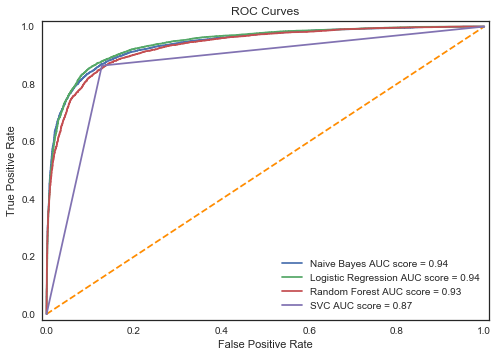

In [65]:
#Plotting the roc curves for each model
sns.set_style('white')
fig, ax = plt.subplots()
ax.plot([0,1], [0,1], linestyle = '--', color = 'darkorange')

probs = [naive_prob, logreg_prob, rf_prob, svm_pred]
labels = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVC']
for idx in range(len(probs)):
    fpr, tpr, thresholds = roc_curve(y_test, probs[idx])
    ax.plot(fpr, tpr, label = (labels[idx] + ' AUC score = %.2f' % roc_auc_score(y_test, probs[idx])))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
ax.legend(loc = 'lower right')
ax.margins(x = 0.01, y =0.02)


plt.show()